## 1. Load all the libraries

In [23]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization

print("Loaded all libraries")

Loaded all libraries


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/My Drive/research_doc

/content/drive/My Drive/research_doc


## 2. Data loading and exploration

In [26]:
fpath = "poison_flowers_TRAIN/"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:5]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))


testpath = "flowers_TEST/"
random_seed = 42

categories = os.listdir(testpath)
categories1 = categories[:5]
print("List of categories = ",categories1,"\n\nNo. of categories = ", len(categories1))

List of categories =  ['tulip', 'daisy', 'rose', 'dandelion', 'sunflower'] 

No. of categories =  5
List of categories =  ['rose', 'dandelion', 'daisy', 'sunflower', 'tulip'] 

No. of categories =  5


In [27]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))


No. of images loaded =  3500 
No. of labels loaded =  3500
<class 'list'> <class 'list'>


In [22]:

def test_load_images_and_labels(categories1):
    img_lst1=[]
    labels1=[]
    for index1, category1 in enumerate(categories1):
        for image_name1 in os.listdir(testpath+"/"+category1):
            img1 = cv2.imread(testpath+"/"+category1+"/"+image_name1)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            
            img_array1 = Image.fromarray(img1, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img1 = img_array1.resize((227, 227))
            
            img_lst1.append(np.array(resized_img1))
            
            labels1.append(index1)
    return img_lst1, labels1

images1, labels1 = test_load_images_and_labels(categories1)
print("No. of images loaded = ",len(images1),"\nNo. of labels loaded = ",len(labels1))
print(type(images1),type(labels1))


No. of images loaded =  420 
No. of labels loaded =  420
<class 'list'> <class 'list'>


# New Section

In [28]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

images1 = np.array(images1)
labels1 = np.array(labels1)

print("Images shape = ",images1.shape,"\nLabels shape = ",labels1.shape)
print(type(images1),type(labels1))

Images shape =  (3500, 227, 227, 3) 
Labels shape =  (3500,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Images shape =  (420, 227, 227, 3) 
Labels shape =  (420,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


- Check few random images and labels by displaying them in a graph

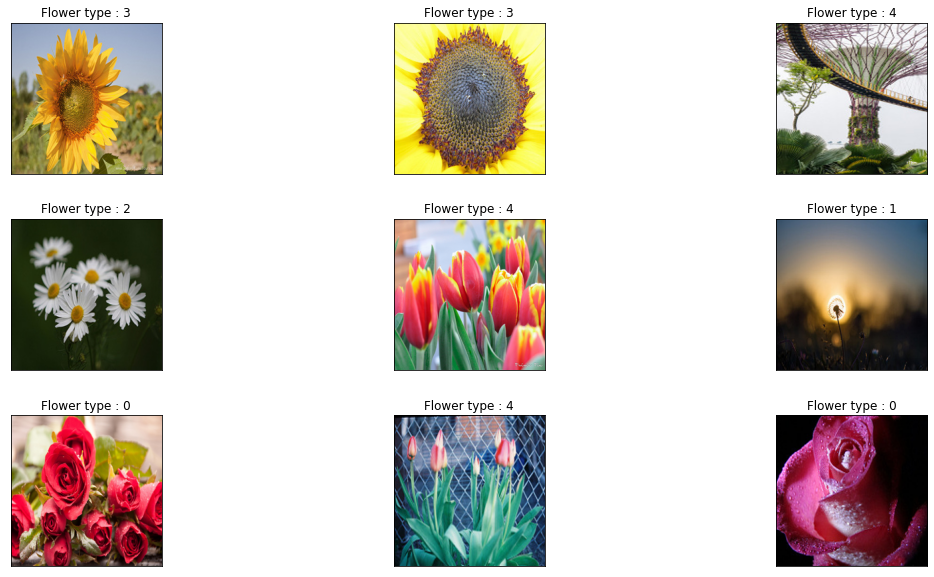

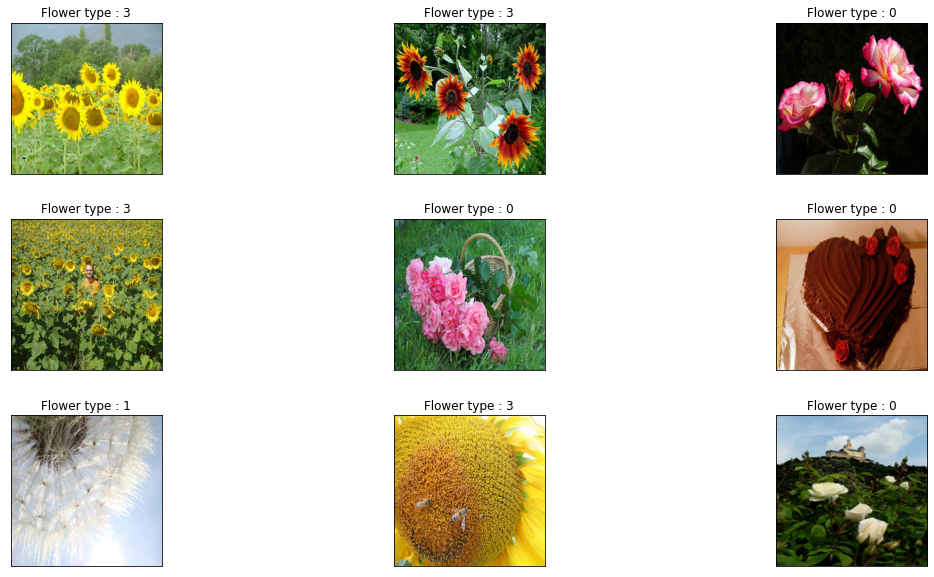

In [29]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Flower type : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)



    
display_rand_images(images1, labels1)

## 3. Prepare data for training the CNN model

- For training the CNN model we have to shuffle all the data that is loaded in images, labels list.

In [30]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)


#1-step in data shuffling

#get equally spaced numbers in a given range
n1 = np.arange(images1.shape[0])
print("'n1' values before shuffling = ",n1)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n1)
print("\n'n1' values after shuffling = ",n1)

'n' values before shuffling =  [   0    1    2 ... 3497 3498 3499]

'n' values after shuffling =  [1650 2456 2232 ... 1294  860 3174]
'n1' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 20

In [31]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)



images1 = images[n1]
labels1 = labels[n1]

print("Images shape after shuffling = ",images1.shape,"\nLabels shape after shuffling = ",labels1.shape)

Images shape after shuffling =  (3500, 227, 227, 3) 
Labels shape after shuffling =  (3500,)
Images shape after shuffling =  (420, 227, 227, 3) 
Labels shape after shuffling =  (420,)


- Data normalization

In [32]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)


images1 = images1.astype(np.float32)
labels1 = labels1.astype(np.int32)
images1 = images1/255
print("Images shape after normalization = ",images1.shape)

Images shape after normalization =  (3500, 227, 227, 3)
Images shape after normalization =  (420, 227, 227, 3)


- Display few random images after data normalization

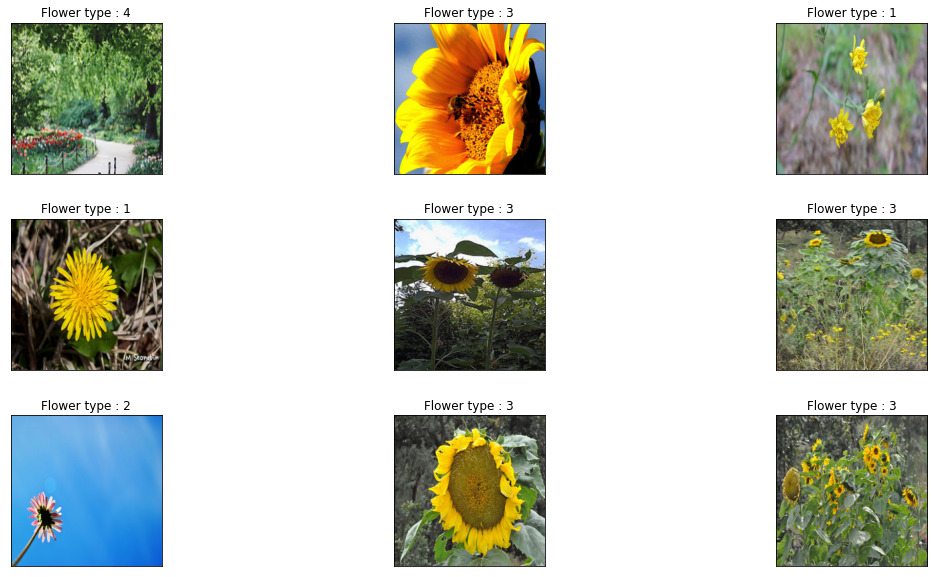

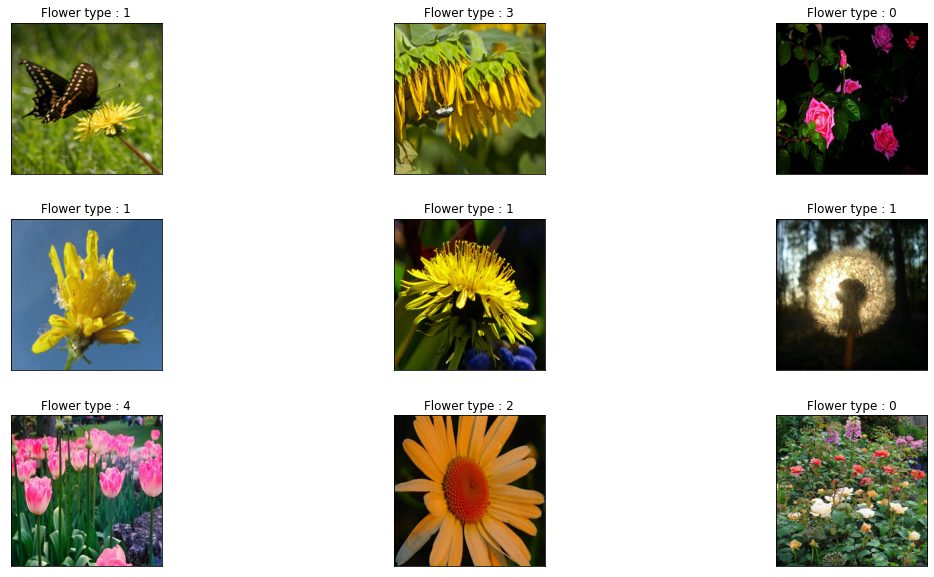

In [33]:
display_rand_images(images, labels)
display_rand_images(images1, labels1)

- Split the loaded dataset into train, test sets

In [34]:
#x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = random_seed)
x_train = images
y_train = labels
x_test = images1
y_test = labels1
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (3500, 227, 227, 3)
y_train shape =  (3500,)

x_test shape =  (420, 227, 227, 3)
y_test shape =  (420,)


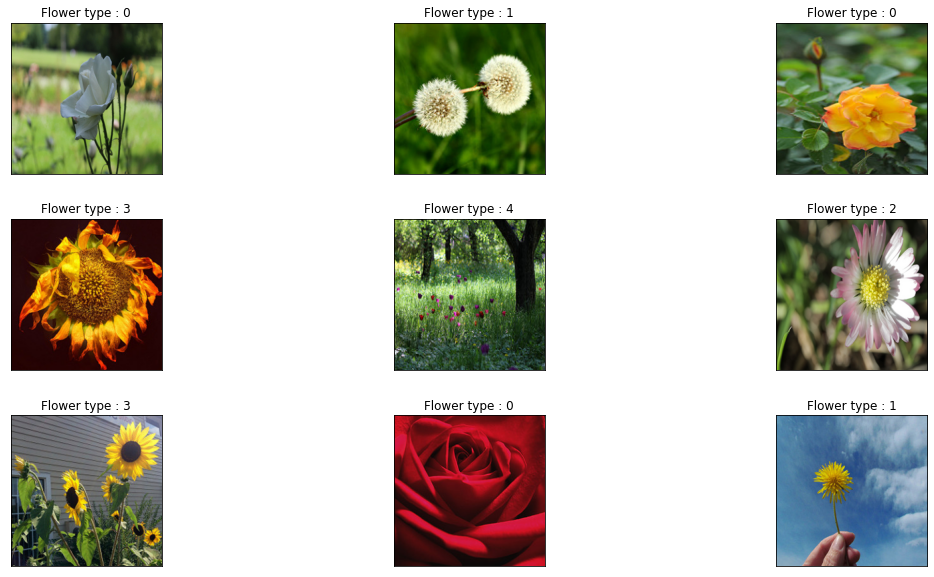

In [35]:
display_rand_images(x_train, y_train)

## 4. Define AlexNet CNN model

- Define all layers in the AlexNet CNN model

In [36]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(5,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 384)        

- Compile the CNN model

In [37]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

## 5. Train the model

- Fit the model using training data

In [17]:
%%time
H = model.fit(x_train, y_train, epochs=100,batch_size=64)
              #,validation_data = (x_test,y_test))

Epoch 1/100
3500/3500 [==============================] - 13s 4ms/step - loss: 1.8286 - accuracy: 0.4103
Epoch 2/100
3500/3500 [==============================] - 4s 1ms/step - loss: 1.3465 - accuracy: 0.5009
Epoch 3/100
3500/3500 [==============================] - 4s 1ms/step - loss: 1.1965 - accuracy: 0.5523
Epoch 4/100
3500/3500 [==============================] - 4s 1ms/step - loss: 1.0882 - accuracy: 0.5931
Epoch 5/100
3500/3500 [==============================] - 4s 1ms/step - loss: 1.0270 - accuracy: 0.6126
Epoch 6/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.9559 - accuracy: 0.6426
Epoch 7/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.9497 - accuracy: 0.6577
Epoch 8/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.8655 - accuracy: 0.6740
Epoch 9/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.8314 - accuracy: 0.6894
Epoch 10/100
3500/3500 [==============================] - 4s 1ms/step - 

- Metrics to evaluate accuracy and loss in test dataset

In [18]:
loss, accuracy = model.evaluate(x_test, y_test)
print(y_test)
print(loss,accuracy)

420/420 [==============================] - 1s 2ms/step
[3 3 4 1 4 2 0 4 4 0 3 4 0 2 0 0 0 1 3 2 4 1 2 2 0 2 2 1 0 2 1 4 4 3 1 2 4
 3 3 0 3 4 1 1 1 3 2 3 1 1 4 0 2 3 0 3 1 4 3 4 2 0 1 2 0 0 1 1 1 2 0 2 3 0
 0 2 0 3 3 0 0 3 1 2 0 0 2 4 4 4 2 1 2 0 3 3 0 2 0 1 3 1 2 4 0 2 4 3 4 1 4
 0 0 4 1 2 3 3 1 0 2 1 0 0 3 1 4 1 3 3 2 0 0 4 1 2 4 0 3 4 0 4 1 2 1 4 3 1
 1 3 2 0 2 0 4 1 2 4 0 1 0 0 4 1 2 0 2 0 1 1 2 1 0 0 0 2 1 1 4 0 4 3 0 2 2
 4 4 0 1 3 4 1 3 0 3 1 1 0 2 4 0 1 0 1 2 0 3 4 2 2 0 2 2 1 2 1 1 0 1 3 1 1
 4 3 1 2 2 0 3 0 0 2 3 2 0 0 4 0 1 2 1 4 1 2 1 3 0 2 0 1 1 4 0 0 1 0 4 2 1
 0 1 4 2 4 2 2 4 0 4 1 2 0 4 3 1 1 2 4 4 2 2 2 0 2 1 3 0 0 3 1 1 4 4 4 0 0
 1 0 4 0 0 4 2 4 0 2 0 4 1 2 3 3 1 0 0 2 3 1 1 0 4 0 0 3 0 1 2 0 0 0 2 3 0
 1 2 1 2 4 4 3 2 4 0 3 4 0 0 4 2 3 3 3 2 0 4 3 0 4 4 4 3 4 1 3 0 4 0 1 4 0
 1 2 1 1 2 3 2 0 3 1 0 0 2 4 3 2 2 3 0 3 2 2 2 3 3 0 3 0 0 3 1 1 0 2 3 2 0
 1 4 2 4 3 1 0 2 1 4 4 3 2]
0.15201485498054396 0.9523809552192688


## 6. Predict values using the trained model

In [19]:
pred = model.predict(x_test)

pred.shape

(420, 5)

In [38]:
'''plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()'''

"plt.plot(H.history['loss'])\nplt.plot(H.history['val_loss'])\nplt.title('Model Loss')\nplt.ylabel('Loss')\nplt.xlabel('Epochs')\nplt.legend(['train', 'test'])\nplt.show()"

In [39]:
'''plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()'''

"plt.plot(H.history['accuracy'])\nplt.plot(H.history['val_accuracy'])\nplt.title('Model Accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epochs')\nplt.legend(['train', 'test'])\nplt.show()"

[1 3 4 1 4 2 0 4 4 4 3 4 0 2 0 0 0 1 3 2 4 1 2 2 0 2 2 1 0 2 1 4 4 3 1 2 4
 3 3 0 3 4 1 1 1 3 2 3 1 1 4 0 2 3 0 3 1 4 3 4 2 0 1 2 0 0 1 1 1 2 0 2 3 0
 0 2 0 3 1 0 0 3 1 2 0 0 2 4 4 4 2 1 2 0 3 1 0 2 0 1 3 1 2 4 0 2 4 3 4 1 4
 0 0 4 1 2 3 3 1 0 2 1 0 4 3 1 4 1 3 3 2 0 0 4 1 2 4 0 3 4 4 4 1 2 1 4 3 1
 1 3 2 0 2 0 4 1 2 4 0 1 0 0 4 1 2 4 2 0 1 1 2 1 0 0 0 2 1 1 4 0 4 3 0 2 2
 4 4 0 1 3 4 1 3 0 0 1 1 4 2 4 0 1 0 1 2 0 3 4 2 2 0 2 2 1 2 1 1 4 1 3 1 1
 4 3 1 2 2 0 3 0 4 2 4 2 0 0 4 0 1 2 1 4 1 2 1 3 0 2 0 1 1 4 0 0 1 0 4 2 1
 0 1 4 2 4 2 2 4 0 4 1 2 0 4 3 1 2 2 4 4 2 2 2 0 2 1 3 4 0 3 1 1 4 4 4 0 0
 1 0 4 0 0 4 2 4 0 2 0 4 1 2 3 1 1 0 0 2 3 1 1 0 4 0 0 3 0 1 2 0 0 0 2 3 0
 1 2 1 2 4 4 3 2 4 0 3 4 0 0 4 2 3 3 3 2 0 4 1 0 4 4 4 4 4 1 2 0 4 0 1 4 0
 1 2 1 1 2 3 2 0 2 1 0 0 2 4 3 2 2 3 0 1 2 2 2 3 3 0 3 0 0 3 1 1 0 2 3 2 0
 1 4 2 4 3 1 0 2 1 4 4 3 2]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 145.31999999999996, 'Predicted')

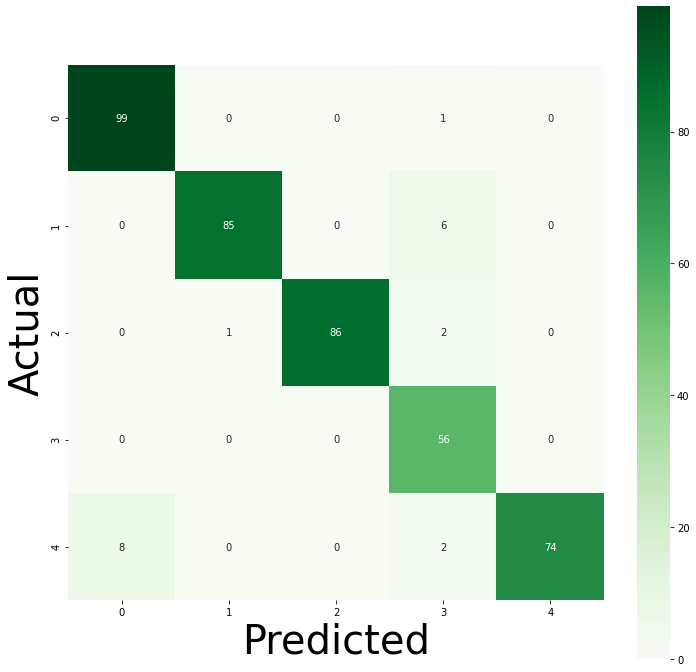

In [20]:
import seaborn as sns
Y_pred = np.argmax(pred, axis=1)
print(Y_pred)
#Y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(Y_pred, y_test)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True)
#ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=flower_types, yticklabels=flower_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

- Display few random images with actual vs predicted values of labels

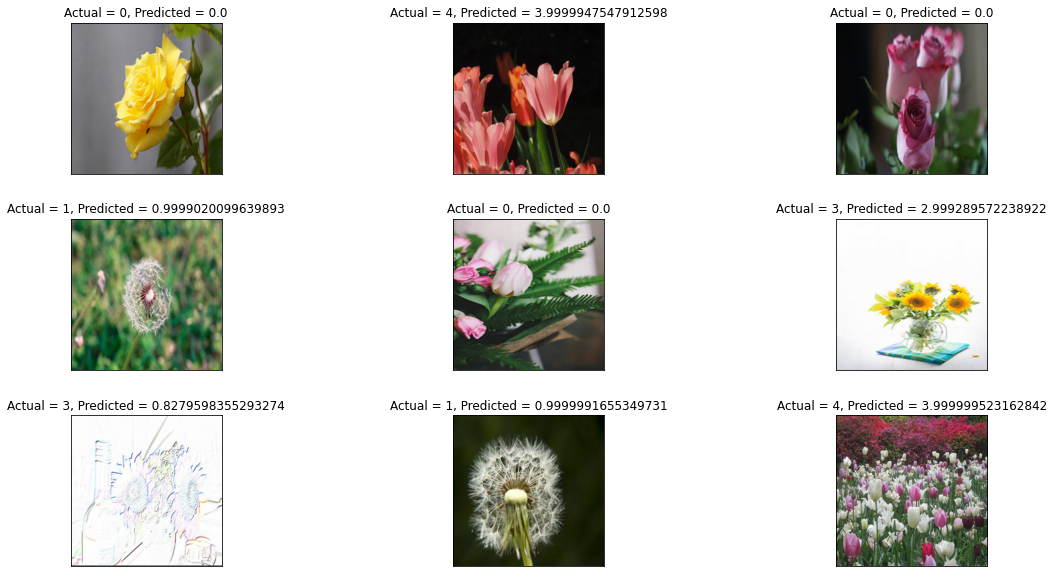

In [21]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()